<a href="https://colab.research.google.com/github/KingYuanSun/Individual-Projects-Finance/blob/master/PortfolioOptimization_EfficientFrontier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [162]:
# Portfolio Optimization - Efficient Frontier - 2020 08 11

In [163]:
# The reason for me to revise/write this program is very simple.
# Let's say I annually saved $10,000, how should I invest the money so I could maximize the returns?

In [164]:
# Install quandl, a financial database 
!pip install quandl

In [165]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import quandl
import scipy.optimize as sco

plt.style.use('fivethirtyeight')

np.random.seed(777)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [166]:
# # For some reasons, quandl can not get the most updated data. So I will use Yahoo finance instead.
# # Get data from the database. Here I am randomly selecting some stocks as examples. 

# quandl.ApiConfig.api_key = 'iD4ZLNZmces67UzBVRLt'
# stocks = ['AAPL','AMZN','GOOGL','FB']
# #stocks = ['TSLA','AAPL','MSFT','FB']
# data = quandl.get_table('WIKI/PRICES', ticker = stocks,
#                         qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
#                         date = { 'gte': '2016-1-1', 'lte': '2018-12-31' }, paginate=True)
# data.head()

# data.info()

# df = data.set_index('date')
# df.head()

# table = df.pivot(columns='ticker')
# # By specifying col[1] in below list comprehension
# # You can select the stock names under multi-level column
# table.columns = [col[1] for col in table.columns]
# #table.head(20)
# table.tail(20)

In [167]:
!pip install yfinance
import yfinance as yf
tickers = ['AAPL','AMZN','GOOGL','FB']
ohlc = yf.download(tickers, start="2016-1-1", end="2018-03-28")
prices = ohlc["Adj Close"]
prices.tail()
table = prices

[*********************100%***********************]  4 of 4 completed


Text(0, 0.5, 'price in $')

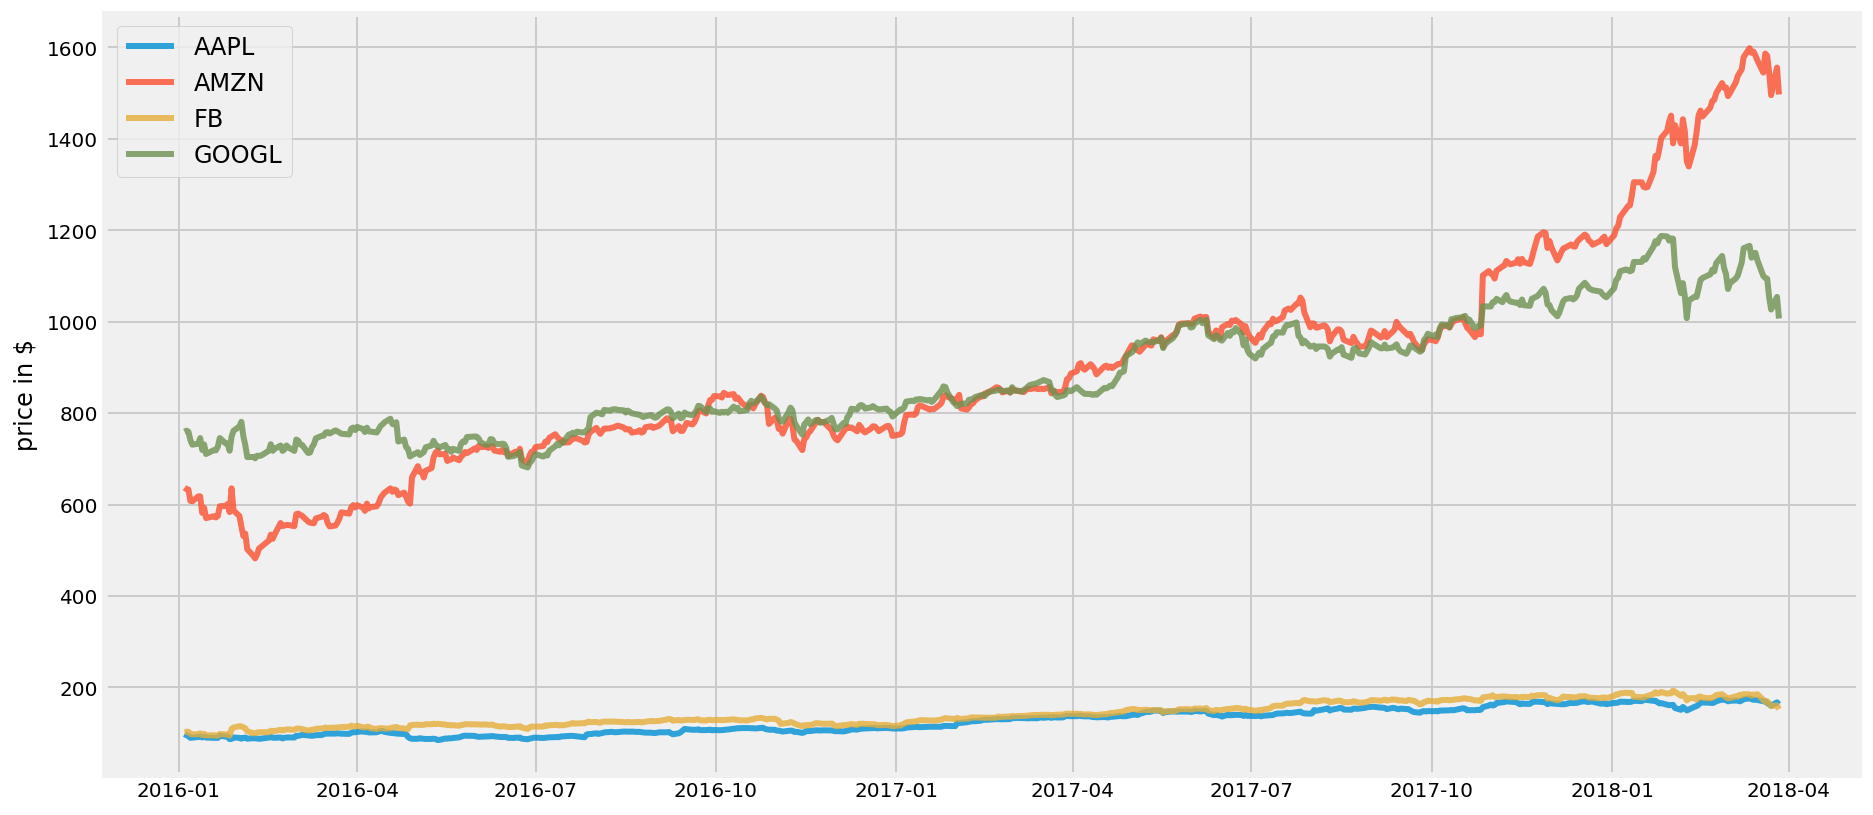

In [168]:
plt.figure(figsize=(14, 7))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

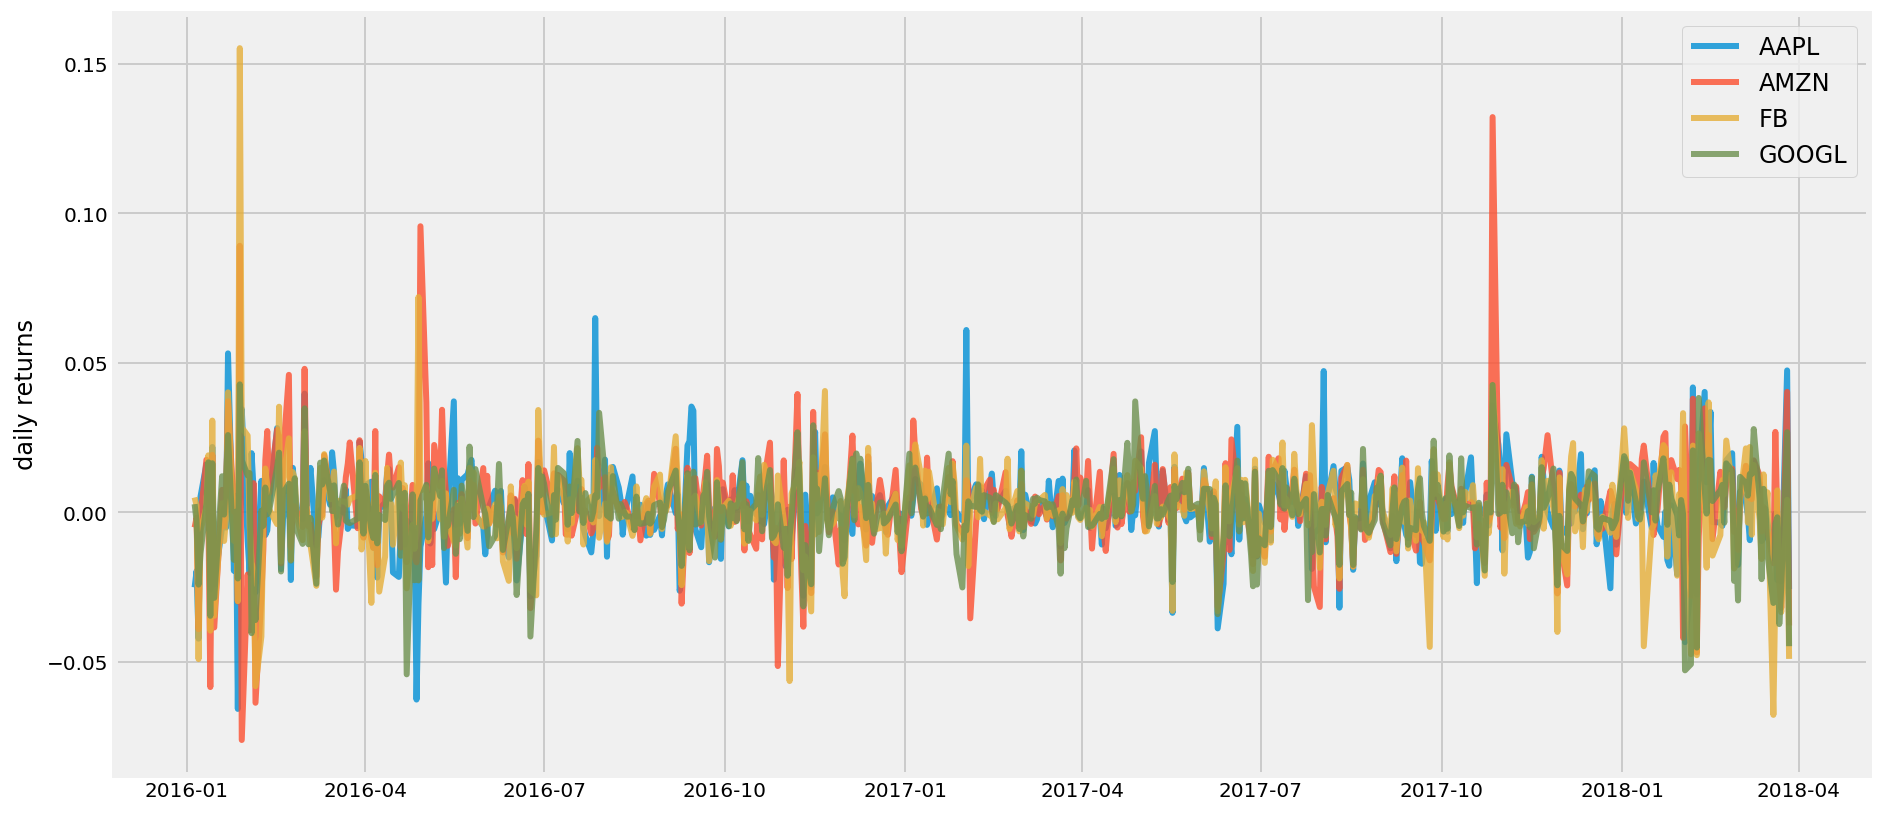

In [169]:
returns = table.pct_change()

plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')
plt.show()

Efficient Frontier

From the plot of the randomly simulated portfolio, we can see it forms a shape of an arch line on the top of clustered blue dots. This line is called efficient frontier. Why is it efficient? Because points along the line will give you the lowest risk for a given target return. All the other dots right to the line will give you higher risk with same returns. If the expected returns are the same, why would you take an extra risk when there's an option with lower risk?

The way we found the two kinds of optimal portfolio above was by simulating many possible random choices and pick the best ones (either minimum risk or maximum risk-adjusted return). We can also implement this by using Scipy's optimize function.

If you are an advanced Excel user, you might be familiar with 'solver' function in excel. Scipy's optimize function is doing the similar task when given what to optimize, and what are constraints and bounds.

Below functions are to get the maximum Sharpe ratio portfolio. In Scipy's optimize function, there's no 'maximize', so as an objective function you need to pass something that should be minimized. That is why the first "neg_sharpe_ratio" is computing the negative Sharpe ratio. Now we can use this as our objective function to minimize. In "max_sharpe_ratio" function, you first define arguments (this should not include the variables you would like to change for optimisation, in this case, "weights"). At first, the construction of constraints was a bit difficult for me to understand, due to the way it is stated.

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

The above constraint is saying that sum of x should be equal to 1. You can think of the 'fun' part construction as '1' on the right side of equal sign has been moved to the left side of the equal sign.

'np.sum(x) == 1' has become 'np.sum(x)-1'

And what does this mean? It simply means that the sum of all the weights should be equal to 1. You cannot allocate more than 100% of your budget in total.

"bounds" is giving another limit to assign random weights, by saying any weight should be inclusively between 0 and 1. You cannot give minus budget allocation to a stock or more than 100% allocation to a stock.

In [170]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [171]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(4)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [172]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [173]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:")
    print (round(rp,2))
    print ("Annualised Volatility:")
    print (round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:")
    print (round(rp_min,2))
    print ("Annualised Volatility:")
    print (round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

    

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return:
0.36
Annualised Volatility:
0.21


             AAPL   AMZN   FB  GOOGL
allocation  32.46  67.54  0.0    0.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return:
0.21
Annualised Volatility:
0.18


             AAPL  AMZN    FB  GOOGL
allocation  37.44  7.67  7.77  47.11


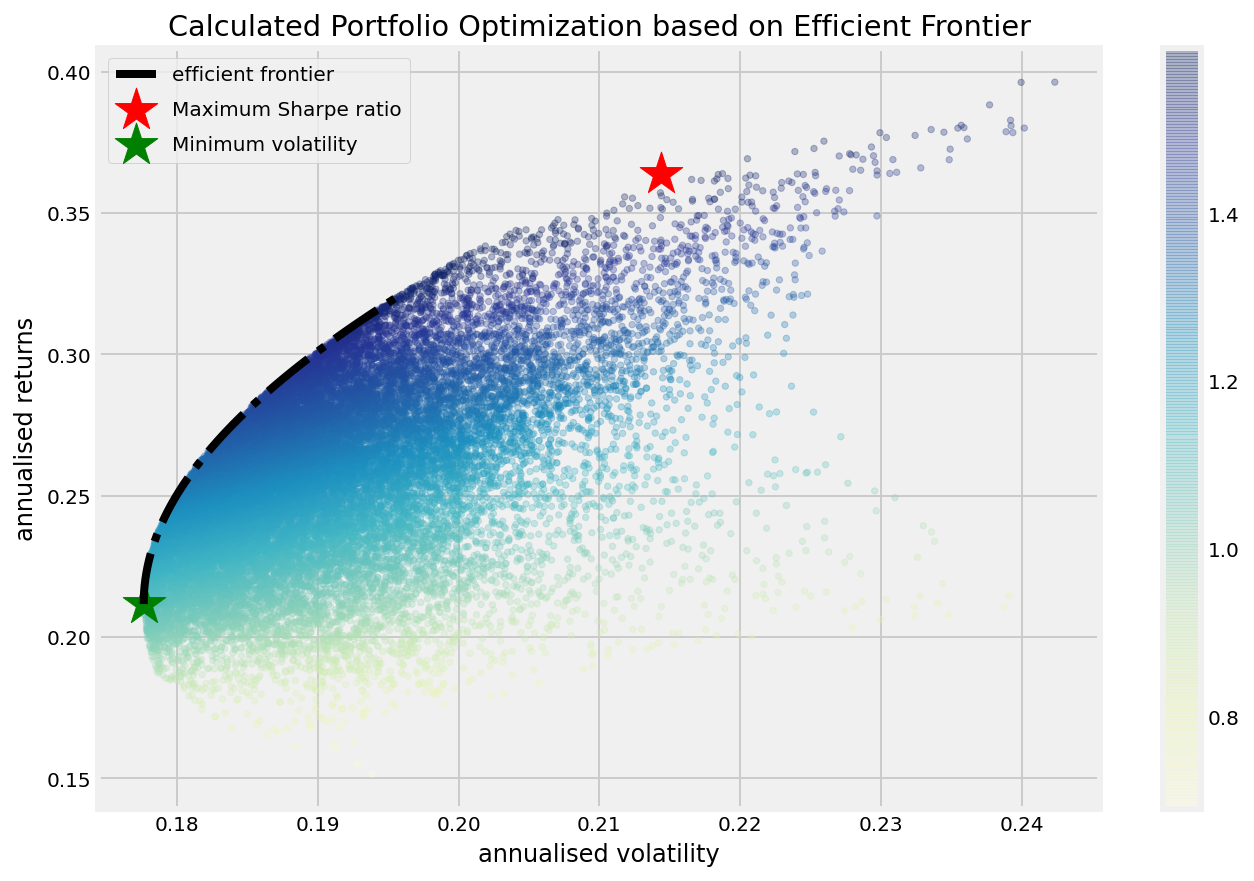

In [174]:
returns = table.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.0178


display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

Now let me try to use open-source library to allocate the money

In [175]:
!pip install PyPortfolioOpt
import pandas as pd
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [176]:
table.tail(20)
df = table
# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# Optimise for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
#ef.save_weights_to_file("weights.csv")  # saves to file
print(cleaned_weights)
ef.portfolio_performance(verbose=True)




OrderedDict([('AAPL', 0.32206), ('AMZN', 0.67794), ('FB', 0.0), ('GOOGL', 0.0)])
Expected annual return: 36.4%
Annual volatility: 21.5%
Sharpe Ratio: 1.60


(0.36418318716167186, 0.2146347920243995, 1.6035759343366167)

In [177]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices


latest_prices = get_latest_prices(df)

da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=10000)
allocation, leftover = da.lp_portfolio()
print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

Discrete allocation: {'AAPL': 15.0, 'AMZN': 5.0}
Funds remaining: $70.69


In [178]:
# Optimise for minimal volatility ratio

ef = EfficientFrontier(mu, S)
raw_weights = ef.min_volatility()
cleaned_weights = ef.clean_weights()
#ef.save_weights_to_file("weights.csv")  # saves to file
print(cleaned_weights)
ef.portfolio_performance(verbose=True)


OrderedDict([('AAPL', 0.37419), ('AMZN', 0.07751), ('FB', 0.07877), ('GOOGL', 0.46953)])
Expected annual return: 21.2%
Annual volatility: 17.8%
Sharpe Ratio: 1.08


(0.2119134288915011, 0.17763881140833257, 1.0803575376912198)

In [179]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices


latest_prices = get_latest_prices(df)

da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=10000)
allocation, leftover = da.lp_portfolio()
print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

Discrete allocation: {'AAPL': 23.0, 'FB': 6.0, 'GOOGL': 5.0}
Funds remaining: $304.43


Now let me try to apply Black-Litterman allocation

In [180]:
tickers = ["MSFT", "AMZN", "NAT", "BAC", "DPZ", "DIS", "KO", "MCD", "COST", "SBUX"]
ohlc = yf.download(tickers, period="max")
prices = ohlc["Adj Close"]
prices.tail()

market_prices = yf.download("SPY", period="max")["Adj Close"]
market_prices.head()

mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


{'AMZN': 1578885316608,
 'BAC': 236833161216,
 'COST': 148586070016,
 'DIS': 237248888832,
 'DPZ': 15359179776,
 'KO': 205880426496,
 'MCD': 153336119296,
 'MSFT': 1568357482496,
 'NAT': 687568832,
 'SBUX': 92654936064}

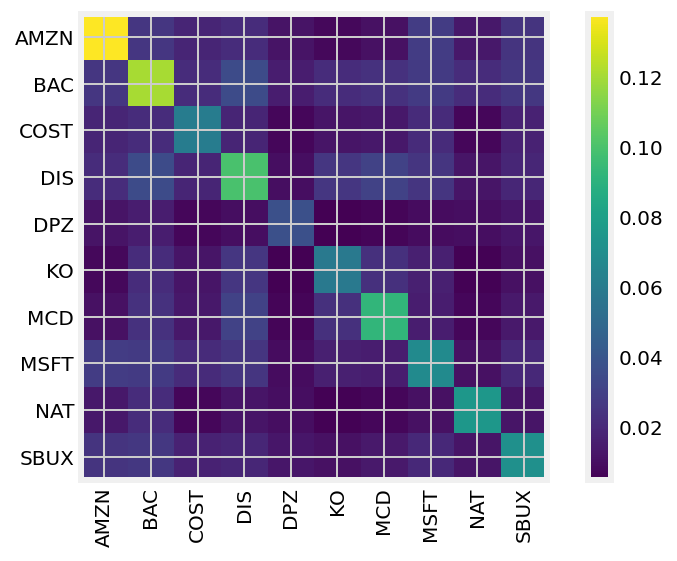

In [181]:
import pypfopt
pypfopt.__version__

from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

plotting.plot_covariance(S);

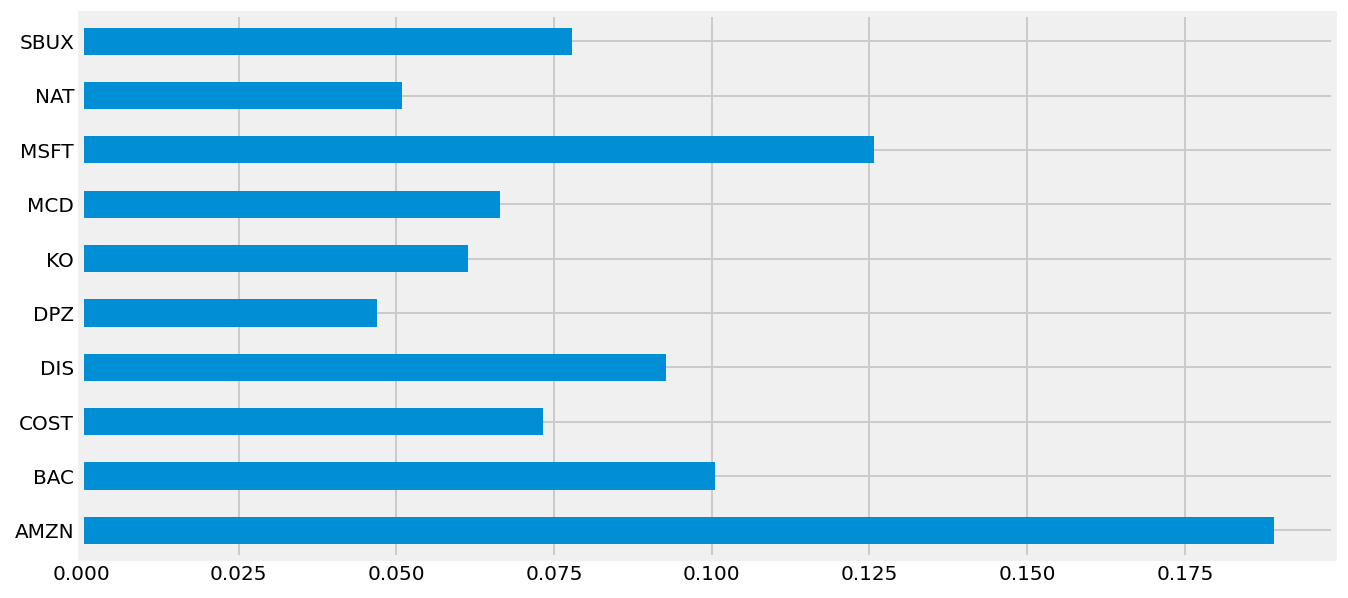

In [182]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

market_prior.plot.barh(figsize=(10,5));

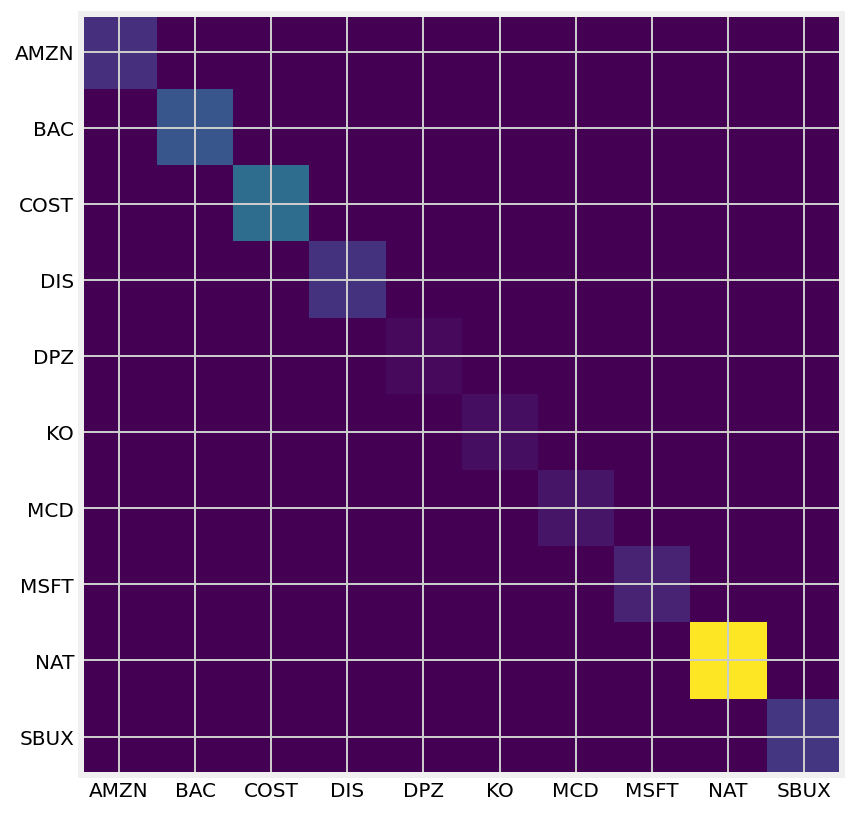

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225]


In [183]:
# You don't have to provide views on all the assets
viewdict = {
    "AMZN": 0.10,
    "BAC": 0.30,
    "COST": 0.05,
    "DIS": 0.05,
    "DPZ": 0.20,
    "KO": -0.05,  # I think Coca-Cola will go down 5%
    "MCD": 0.15,
    "MSFT": 0.10,
    "NAT": 0.50,  # but low confidence, which will be reflected later
    "SBUX": 0.10
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.7, # confident in dominos
    0.7, # confident KO will do poorly
    0.7, 
    0.5,
    0.1,
    0.4
]

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3)
]

variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

In [184]:

# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_averison="delta",
                        absolute_views=viewdict, omega=omega)

# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AMZN,0.189159,0.112541,0.10
BAC,0.100561,0.148167,0.30
COST,0.073197,0.052241,0.05
DIS,0.092692,0.066890,0.05
DPZ,0.046868,0.099967,0.20
KO,0.061344,0.002559,-0.05
MCD,0.066372,0.106216,0.15
MSFT,0.125706,0.094642,0.10
NAT,0.050909,0.061815,0.50
SBUX,0.077854,0.075415,0.10


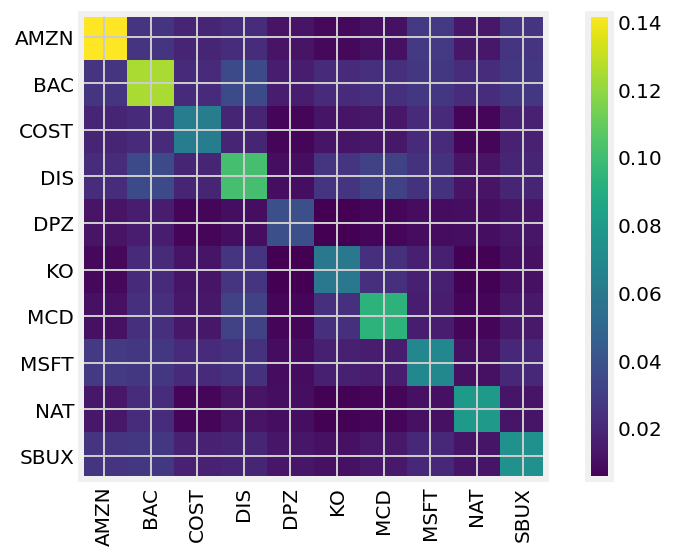

In [185]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

/usr/local/lib/python3.6/dist-packages/pypfopt/efficient_frontier.py:182: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."


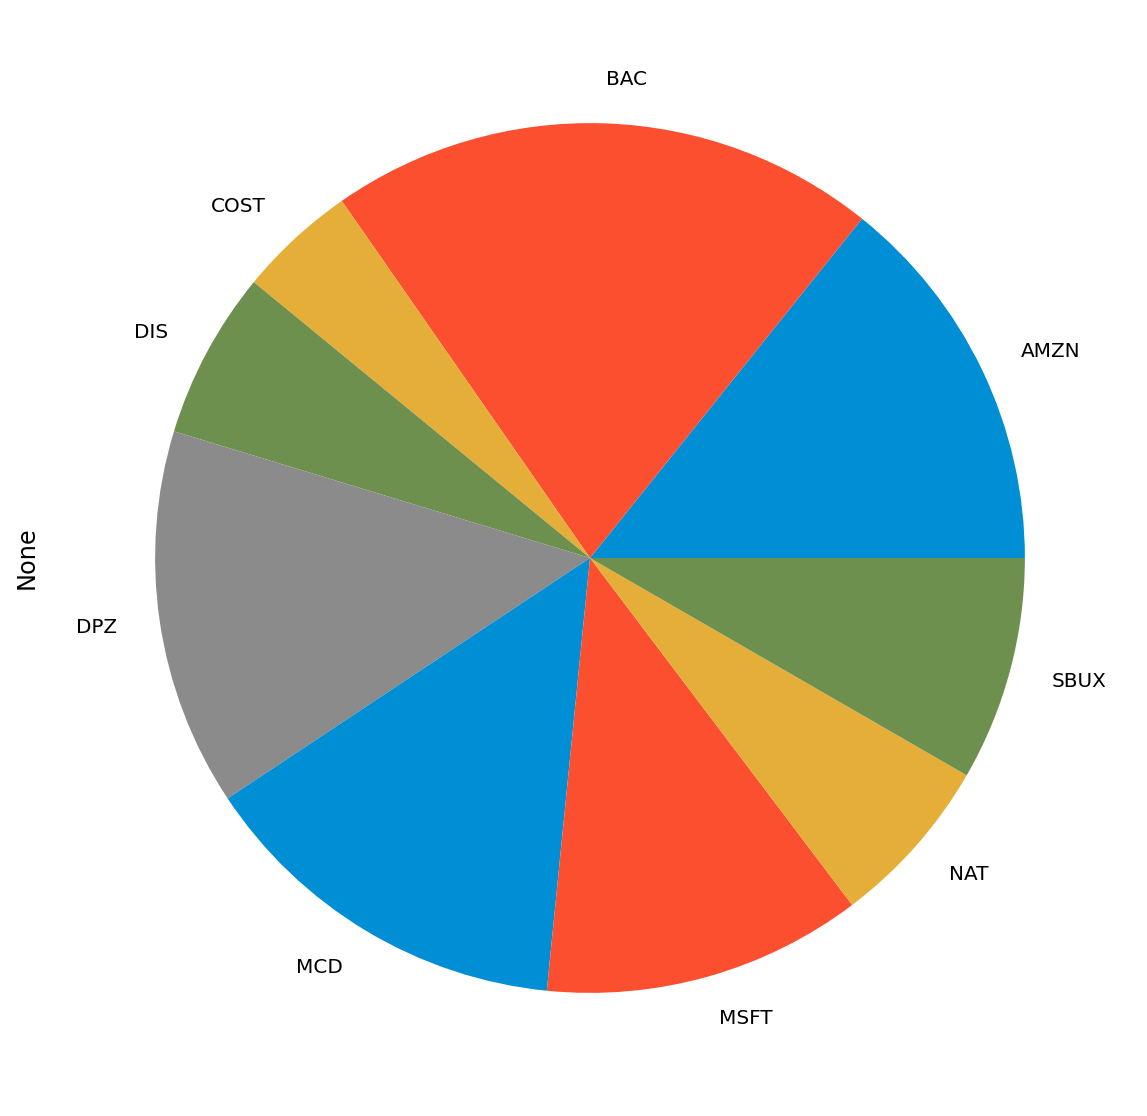

In [186]:
from pypfopt import EfficientFrontier, objective_functions

ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

pd.Series(weights).plot.pie(figsize=(10,10));

In [187]:
from pypfopt import EfficientFrontier, objective_functions

ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights



/usr/local/lib/python3.6/dist-packages/pypfopt/efficient_frontier.py:182: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."


OrderedDict([('AMZN', 0.14244),
             ('BAC', 0.20424),
             ('COST', 0.04398),
             ('DIS', 0.0623),
             ('DPZ', 0.14031),
             ('KO', 0.0),
             ('MCD', 0.14091),
             ('MSFT', 0.11882),
             ('NAT', 0.06374),
             ('SBUX', 0.08328)])

In [188]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=10000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $859.46


{'BAC': 75.0,
 'COST': 2.0,
 'DIS': 5.0,
 'DPZ': 4.0,
 'MCD': 7.0,
 'MSFT': 6.0,
 'NAT': 137.0,
 'SBUX': 11.0}